<a href="https://colab.research.google.com/github/BrianMutisyo/Lets-Go-Sixers/blob/main/Kaggle_Classification_AnkitV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello world!

# Sam's Section

# Ankit's Section

Loading the training and test data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

Remove output column in training data and assign it as the label to predict

In [ ]:
# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

In [ ]:
# Define categorical columns to be encoded
categorical_columns = ['subject', 'phase', 'state']

In [ ]:
# One-hot encoding for categorical columns
onehot_encoder = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
], remainder='passthrough')

In [ ]:
# Transform the train and test data
X_encoded = onehot_encoder.fit_transform(X)
test_data_encoded = onehot_encoder.transform(test_data)

In [ ]:
# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

Training a random forest classifier

In [ ]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Validate the model
y_val_pred = rf_model.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Accuracy: 0.8571


In [ ]:
# Predict on the test data
test_predictions = rf_model.predict(test_data_encoded)

In [ ]:
# Format the predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})

In [ ]:
# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [ ]:
print("Predictions saved to submission.csv")

Predictions saved to submission.csv


This results in test accuracy in Kaggle of 54%

Trying below Enhancements
* Scaling: The numeric columns are scaled using StandardScaler to help the model handle numeric values more efficiently.
* Hyperparameter Tuning: GridSearchCV is used to find the best combination of Random Forest hyperparameters.
* Cross-Validation: Instead of using a single validation split, k-fold cross-validation (with cv=5) gives a more robust score.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing: One-hot encoding for categorical columns, scaling for numeric columns
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Define XGBoost model with GPU support
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='logloss')

# Define a pipeline: preprocessing followed by XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Randomized Search Parameters
param_distributions = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

# RandomizedSearchCV with parallelization and GPU-accelerated XGBoost
random_search = RandomizedSearchCV(
    pipeline, param_distributions, n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1
)

# Fit the model
random_search.fit(X, y)

# Best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-validation Score: {random_search.best_score_:.4f}")

# Predict on the test data
test_data_encoded = random_search.best_estimator_.named_steps['preprocessor'].transform(test_data)
test_predictions = random_search.best_estimator_.named_steps['classifier'].predict(test_data_encoded)

# Format the predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})

# Save the predictions to a CSV file
submission_df.to_csv('submission_gpu.csv', index=False)

print("Predictions saved to submission_gpu.csv")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:04:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.1}
Best Cross-validation Score: 0.8656
Predictions saved to submission_gpu.csv


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:04:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
import optuna
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing: One-hot encoding for categorical columns, scaling for numeric columns
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'tree_method': 'hist',  # Faster on GPU
        'device': 'cuda',  # GPU support
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0)
    }

    # Train XGBoost model
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)

    # Validate the model
    score = model.score(X_valid, y_valid)
    return score

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train on full data using best hyperparameters
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Predict on the test data
test_data_encoded = preprocessor.transform(test_data)
test_predictions = best_model.predict(test_data_encoded)

# Format the predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})

# Save the predictions to a CSV file
submission_df.to_csv('submission_optuna.csv', index=False)

print("Predictions saved to submission_optuna.csv")

[I 2024-10-19 18:09:19,371] A new study created in memory with name: no-name-0cd94eea-f786-44ac-b931-ca998f26d2ef
<ipython-input-3-aa0f503babcb>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-3-aa0f503babcb>:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-3-aa0f503babcb>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_logunifo

Best Hyperparameters: {'n_estimators': 160, 'max_depth': 12, 'learning_rate': 0.06806890658910449, 'subsample': 0.9995021266803916, 'colsample_bytree': 0.6285817854072765, 'lambda': 0.11019480721665534, 'alpha': 0.005958951726100463}
Predictions saved to submission_optuna.csv


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 22.0 MB/s eta 0:00:00


In [ ]:
pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00


* Memory Management: The code optimizes the data types and uses a subset of the training data to manage memory consumption effectively.
* Preprocessing: It includes target encoding for categorical features and scales numeric features.
* Polynomial Features: Polynomial features are applied with interactions only, helping to reduce dimensionality.
* Optuna Integration: It includes a hyperparameter tuning setup using Optuna for the XGBoost model.
* Stacking Classifier: It combines predictions from XGBoost, LightGBM, and CatBoost for better performance.

In [ ]:
pip install --upgrade xgboost

In [ ]:
gc.collect()

1096

In [ ]:
gc.collect()

111346

In [ ]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

[I 2024-10-19 19:18:08,831] A new study created in memory with name: no-name-34f5de8d-b518-4abc-b92f-f7a5886c8a75


Loading data took 0.54 seconds
Splitting data took 0.01 seconds
Creating preprocessor took 0.00 seconds
Applying target encoding took 0.10 seconds


[I 2024-10-19 19:18:11,160] Trial 0 finished with value: 0.8538713195201745 and parameters: {'n_estimators': 776, 'max_depth': 3, 'learning_rate': 0.04353396078675053, 'subsample': 0.5039884802499481, 'colsample_bytree': 0.8838428159709926, 'lambda': 0.023868234768160555, 'alpha': 0.087621776680293}. Best is trial 0 with value: 0.8538713195201745.
[I 2024-10-19 19:18:17,406] Trial 1 finished with value: 0.8407851690294439 and parameters: {'n_estimators': 319, 'max_depth': 9, 'learning_rate': 0.002831956461430996, 'subsample': 0.7380920520451759, 'colsample_bytree': 0.6645893938266938, 'lambda': 0.5319219126984857, 'alpha': 5.382835728697154}. Best is trial 0 with value: 0.8538713195201745.
[I 2024-10-19 19:18:18,717] Trial 2 finished with value: 0.8386041439476554 and parameters: {'n_estimators': 498, 'max_depth': 3, 'learning_rate': 0.0015340798339090504, 'subsample': 0.626835598416845, 'colsample_bytree': 0.7391119959318266, 'lambda': 0.0003108046901624853, 'alpha': 0.693600887622196

Running Optuna study took 205.97 seconds
Best Hyperparameters: {'n_estimators': 1462, 'max_depth': 6, 'learning_rate': 0.008252647239585268, 'subsample': 0.8798353150886109, 'colsample_bytree': 0.9915078582609945, 'lambda': 0.0021412922470020242, 'alpha': 1.1851271361097405e-05}
Training final XGBoost model took 55.63 seconds


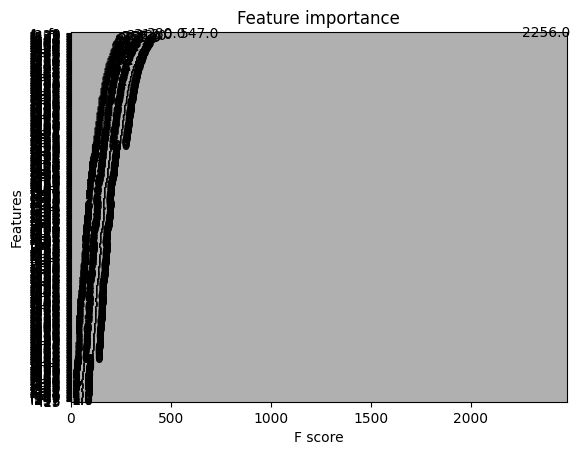

Plotting feature importance took 4.16 seconds
Preparing test data took 0.03 seconds


Training stacking model took 577.64 seconds
Making predictions took 0.05 seconds
Saving predictions took 0.00 seconds
Predictions saved to submission_stacked2.csv


119706

In [ ]:
import optuna
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import time
import gc

# Function to monitor time
class MonitorTime:
    def __init__(self, step):
        self.step = step

    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        end_time = time.time()
        print(f"{self.step} took {end_time - self.start_time:.2f} seconds")

# Load the data
with MonitorTime("Loading data"):
    train_data = pd.read_csv('train_data.csv')  # Use full data for training
    test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
with MonitorTime("Splitting data"):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline
def create_preprocessor():
    with MonitorTime("Creating preprocessor"):
        preprocessor = ColumnTransformer([
            ('target_encode', ce.TargetEncoder(cols=categorical_columns), categorical_columns),
            ('scaler', StandardScaler(), numeric_columns)
        ])
    return preprocessor

preprocessor = create_preprocessor()

# Fit and transform the training data with target encoding
with MonitorTime("Applying target encoding"):
    X_train_transformed = preprocessor.fit_transform(X_train, y_train)
    X_valid_transformed = preprocessor.transform(X_valid)

def objective(trial):
    param = {
        'tree_method': 'gpu_hist',
        'device': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),  # Wider range
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Increased max depth
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),  # Broader range
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-5, 10.0, log=True),  # Broader range
        'alpha': trial.suggest_float('alpha', 1e-5, 10.0, log=True)   # Broader range
    }

    model = xgb.XGBClassifier(**param)
    model.fit(X_train_transformed, y_train)
    return model.score(X_valid_transformed, y_valid)

# Create Optuna study for hyperparameter tuning
with MonitorTime("Running Optuna study"):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)  # Limit trials to manage memory

# Display best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train best XGBoost model
xgb_model = xgb.XGBClassifier(**study.best_params)
with MonitorTime("Training final XGBoost model"):
    xgb_model.fit(X_train_transformed, y_train)

# Feature Importance Plot
with MonitorTime("Plotting feature importance"):
    xgb.plot_importance(xgb_model)
    plt.show()

# Prepare test data for prediction
with MonitorTime("Preparing test data"):
    test_data_encoded = preprocessor.transform(test_data)

# CatBoost Classifier
catboost_model = CatBoostClassifier(task_type='GPU', verbose=0)  # CatBoost with GPU

# Stacking model
stacked_model = StackingClassifier(
    estimators=[('xgb', xgb_model), ('catboost', catboost_model)],
    final_estimator=xgb.XGBClassifier()  # Using XGBoost as the final estimator
)

# Train and predict using stacking
with MonitorTime("Training stacking model"):
    stacked_model.fit(X_train_transformed, y_train)

with MonitorTime("Making predictions"):
    test_predictions = stacked_model.predict(test_data_encoded)

# Save predictions for submission
with MonitorTime("Saving predictions"):
    submission_df = pd.DataFrame({
        'id': test_data.index,
        'output': test_predictions
    })
    submission_df.to_csv('submission_stacked.csv', index=False)

print("Predictions saved to submission_stacked2.csv")

# Clean up memory
gc.collect()

The results of xgboost and other enhancement do not very different test results than in past.

As training data has imbalance with label 0 being minority class, trying SMOTE to mitigate data imbalance

In [ ]:
pip install imbalanced-learn

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from category_encoders import TargetEncoder

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('target_encode', TargetEncoder(cols=categorical_columns), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Apply preprocessing to training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)  # Pass y_train here
X_valid_transformed = preprocessor.transform(X_valid)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Train XGBoost model with balanced data and specified hyperparameters
model = xgb.XGBClassifier(
    n_estimators=1462,
    max_depth=6,
    learning_rate=0.008252647239585268,
    subsample=0.8798353150886109,
    colsample_bytree=0.9915078582609945,
    reg_lambda=0.0021412922470020242,  # Fixed from lambda to reg_lambda
    alpha=1.1851271361097405e-05,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='mlogloss'  # Set an appropriate evaluation metric
)

model.fit(X_train_balanced, y_train_balanced)

# Validate the model
y_pred = model.predict(X_valid_transformed)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

# Prepare test data for prediction
test_data_transformed = preprocessor.transform(test_data)
test_predictions = model.predict(test_data_transformed)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})
submission_df.to_csv('submission_xgb_smote.csv', index=False)

print("Predictions saved to submission_xgb_smote.csv")

Validation Accuracy: 0.8669574700109052
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.37      0.47       148
           1       0.89      0.96      0.92       769

    accuracy                           0.87       917
   macro avg       0.77      0.67      0.70       917
weighted avg       0.85      0.87      0.85       917

Predictions saved to submission_xgb_smote.csv


In [ ]:
import gc
gc.collect()

54

This improves test accuracy from 54% to 61%. So this is a good direction.

Trying neural networks to see if that helps improve test accuracy

In [ ]:
pip install torch torchvision torchaudio

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load your data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Check for non-numeric columns
print(train_data.dtypes)

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Define categorical and numeric columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(), categorical_columns)
])

# Apply the preprocessing to your dataset
X_transformed = preprocessor.fit_transform(X)

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Convert the data into tensors for PyTorch
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train.values).long()

X_valid_tensor = torch.tensor(X_valid).float()
y_valid_tensor = torch.tensor(y_valid.values).long()

# Create DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(y.unique())  # Number of output classes
model = SimpleNN(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluation on validation data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

x1           int64
x2           int64
x3           int64
x4           int64
x5         float64
            ...   
z222       float64
subject     object
phase        int64
state       object
output       int64
Length: 670, dtype: object
Epoch [1/20], Loss: 0.4246436735858088
Epoch [2/20], Loss: 0.3701604314472364
Epoch [3/20], Loss: 0.33908496771169744
Epoch [4/20], Loss: 0.31109429792217586
Epoch [5/20], Loss: 0.29127054719821266
Epoch [6/20], Loss: 0.2687688674615777
Epoch [7/20], Loss: 0.24375930078651595
Epoch [8/20], Loss: 0.22506670653820038
Epoch [9/20], Loss: 0.20976838012752325
Epoch [10/20], Loss: 0.2032266502795012
Epoch [11/20], Loss: 0.17374949678778648
Epoch [12/20], Loss: 0.15724096431032472
Epoch [13/20], Loss: 0.15463693608408388
Epoch [14/20], Loss: 0.14880875860867293
Epoch [15/20], Loss: 0.1248208956549997
Epoch [16/20], Loss: 0.11637893782361694
Epoch [17/20], Loss: 0.1089136201078477
Epoch [18/20], Loss: 0.09965925351109194
Epoch [19/20], Loss: 0.0850598821659451
E

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load your data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Define categorical and numeric columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(), categorical_columns)
])

# Apply the preprocessing to your dataset
X_transformed = preprocessor.fit_transform(X)

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Convert the data into tensors for PyTorch
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train.values).long()

X_valid_tensor = torch.tensor(X_valid).float()
y_valid_tensor = torch.tensor(y_valid.values).long()

# Create DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

# Define the enhanced neural network
class EnhancedNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EnhancedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)

        self.fc3 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 128  # Increased size of the hidden layer
num_classes = len(y.unique())  # Number of output classes
model = EnhancedNN(input_size, hidden_size, num_classes)

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with improvements
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()  # Update the learning rate

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluation on validation data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Epoch [1/20], Loss: 0.46917218946177386
Epoch [2/20], Loss: 0.4021368383847434
Epoch [3/20], Loss: 0.3878478865171301
Epoch [4/20], Loss: 0.3710547539180723
Epoch [5/20], Loss: 0.3606165914699949
Epoch [6/20], Loss: 0.3358851619835558
Epoch [7/20], Loss: 0.32835103674181576
Epoch [8/20], Loss: 0.3169963801729268
Epoch [9/20], Loss: 0.3129342134142744
Epoch [10/20], Loss: 0.29698213189840317
Epoch [11/20], Loss: 0.28886267619914024
Epoch [12/20], Loss: 0.2806277359867918
Epoch [13/20], Loss: 0.2657181251922558
Epoch [14/20], Loss: 0.2689751563914891
Epoch [15/20], Loss: 0.2612591352442215
Epoch [16/20], Loss: 0.25263171720093697
Epoch [17/20], Loss: 0.24809935020989385
Epoch [18/20], Loss: 0.2503225600411152
Epoch [19/20], Loss: 0.24254371123067264
Epoch [20/20], Loss: 0.24577735724120303
Validation Accuracy: 84.19%


This did not lead to any improvement in test accuracy

In [ ]:
# Install necessary packages
!pip install torch torchvision

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline with handle_unknown parameter
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)
X_test_transformed = preprocessor.transform(test_data)

# Convert the data into PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_transformed)  # No need for .toarray() here
y_train_tensor = torch.LongTensor(y_train.values)
X_valid_tensor = torch.FloatTensor(X_valid_transformed)
y_valid_tensor = torch.LongTensor(y_valid.values)
X_test_tensor = torch.FloatTensor(X_test_transformed)

# Create a Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
valid_dataset = CustomDataset(X_valid_tensor, y_valid_tensor)
test_dataset = CustomDataset(X_test_tensor, None)  # No labels for test data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Adjust the output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define the loss function and optimizer
model = SimpleNN(X_train_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid_tensor)
        _, predicted = torch.max(valid_outputs, 1)
        acc = (predicted == y_valid_tensor).float().mean()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {acc.item()*100:.2f}%')

# Prepare test data predictions
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predictions = torch.max(test_outputs, 1)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,  # Assuming the test data has an index or unique ID
    'output': test_predictions.numpy()  # Convert tensor to numpy array
})
submission_df.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")

Epoch [1/20], Loss: 0.3076, Validation Accuracy: 83.86%
Epoch [2/20], Loss: 0.3692, Validation Accuracy: 83.75%
Epoch [3/20], Loss: 0.3993, Validation Accuracy: 84.62%
Epoch [4/20], Loss: 0.1882, Validation Accuracy: 83.97%
Epoch [5/20], Loss: 0.5604, Validation Accuracy: 84.51%
Epoch [6/20], Loss: 0.4467, Validation Accuracy: 84.30%
Epoch [7/20], Loss: 0.3913, Validation Accuracy: 83.97%
Epoch [8/20], Loss: 0.2076, Validation Accuracy: 83.97%
Epoch [9/20], Loss: 0.1128, Validation Accuracy: 83.97%
Epoch [10/20], Loss: 0.3575, Validation Accuracy: 83.42%
Epoch [11/20], Loss: 0.0947, Validation Accuracy: 83.42%
Epoch [12/20], Loss: 0.1783, Validation Accuracy: 82.01%
Epoch [13/20], Loss: 0.0425, Validation Accuracy: 82.99%
Epoch [14/20], Loss: 0.3540, Validation Accuracy: 82.33%
Epoch [15/20], Loss: 0.0652, Validation Accuracy: 82.55%
Epoch [16/20], Loss: 0.0604, Validation Accuracy: 82.77%
Epoch [17/20], Loss: 0.0310, Validation Accuracy: 83.42%
Epoch [18/20], Loss: 0.1451, Validation 

In [ ]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.2 MB/s eta 0:00:00


Trying out feature selection to see if that helps

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectFromModel

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('target_encode', TargetEncoder(cols=categorical_columns), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Apply preprocessing to training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)  # Pass y_train here
X_valid_transformed = preprocessor.transform(X_valid)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Feature selection using XGBoost
xgb_fs = xgb.XGBClassifier(
    n_estimators=1462,
    max_depth=6,
    learning_rate=0.008252647239585268,
    subsample=0.8798353150886109,
    colsample_bytree=0.9915078582609945,
    reg_lambda=0.0021412922470020242,
    alpha=1.1851271361097405e-05,
    scale_pos_weight=3,  # Adjusted for class imbalance
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_fs.fit(X_train_balanced, y_train_balanced)
selector = SelectFromModel(xgb_fs, prefit=True)

# Select important features
X_train_selected = selector.transform(X_train_balanced)
X_valid_selected = selector.transform(X_valid_transformed)

# Train final XGBoost model with selected features
model = xgb.XGBClassifier(
    n_estimators=1462,
    max_depth=6,
    learning_rate=0.008252647239585268,
    subsample=0.8798353150886109,
    colsample_bytree=0.9915078582609945,
    reg_lambda=0.0021412922470020242,
    alpha=1.1851271361097405e-05,
    scale_pos_weight=3,  # Adjusted for class imbalance
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train_selected, y_train_balanced)

# Validate the model
y_pred = model.predict(X_valid_selected)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

# Prepare test data for prediction
test_data_transformed = preprocessor.transform(test_data)
test_data_selected = selector.transform(test_data_transformed)
test_predictions = model.predict(test_data_selected)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})
submission_df.to_csv('submission_xgb_fs_smote.csv', index=False)

print("Predictions saved to submission_xgb_fs_smote.csv")

Validation Accuracy: 0.8604143947655398
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.23      0.35       148
           1       0.87      0.98      0.92       769

    accuracy                           0.86       917
   macro avg       0.79      0.61      0.63       917
weighted avg       0.84      0.86      0.83       917

Predictions saved to submission_xgb_fs_smote.csv


This leads to reduction in recall of label 0

Trying out lasso to reduce features

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from category_encoders import TargetEncoder
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('target_encode', TargetEncoder(cols=categorical_columns), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Apply preprocessing to training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)  # Pass y_train here
X_valid_transformed = preprocessor.transform(X_valid)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Feature selection using LassoCV (L1 regularization)
lasso = LassoCV(cv=5, random_state=42).fit(X_train_balanced, y_train_balanced)

# Select important features
lasso_selector = SelectFromModel(lasso, prefit=True)
X_train_lasso_selected = lasso_selector.transform(X_train_balanced)
X_valid_lasso_selected = lasso_selector.transform(X_valid_transformed)

# Train final XGBoost model with selected features
model = xgb.XGBClassifier(
    n_estimators=1462,
    max_depth=6,
    learning_rate=0.008252647239585268,
    subsample=0.8798353150886109,
    colsample_bytree=0.9915078582609945,
    reg_lambda=0.0021412922470020242,
    alpha=1.1851271361097405e-05,
    scale_pos_weight=4,  # Focus more on minority class
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train_lasso_selected, y_train_balanced)

# Validate the model
y_pred = model.predict(X_valid_lasso_selected)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

# Prepare test data for prediction
test_data_transformed = preprocessor.transform(test_data)
test_data_lasso_selected = lasso_selector.transform(test_data_transformed)
test_predictions = model.predict(test_data_lasso_selected)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})
submission_df.to_csv('submission_xgb_lasso_smote.csv', index=False)

print("Predictions saved to submission_xgb_lasso_smote.csv")

Validation Accuracy: 0.8538713195201745
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.19      0.29       148
           1       0.86      0.98      0.92       769

    accuracy                           0.85       917
   macro avg       0.76      0.59      0.61       917
weighted avg       0.83      0.85      0.82       917

Predictions saved to submission_xgb_lasso_smote.csv


This reduces label 0 recall further to 19%

Trying out focal loss to add higher importance to minority class to get right  

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectFromModel

# Custom Focal Loss Objective for XGBoost
def focal_loss(alpha, gamma):
    def focal_loss_obj(preds, dtrain):
        labels = dtrain.get_label()
        preds = 1.0 / (1.0 + np.exp(-preds))  # Sigmoid
        loss = -alpha * labels * np.power(1 - preds, gamma) * np.log(preds) - \
               (1 - alpha) * (1 - labels) * np.power(preds, gamma) * np.log(1 - preds)
        grad = alpha * (preds - labels) * np.power(1 - preds, gamma - 1) * gamma
        hess = alpha * np.power(1 - preds, gamma - 1) * (1 - 2 * preds) * gamma + grad * (1 - grad)
        return grad, hess
    return focal_loss_obj

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('target_encode', TargetEncoder(cols=categorical_columns), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Apply preprocessing to training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)  # Pass y_train here
X_valid_transformed = preprocessor.transform(X_valid)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Feature selection using SelectFromModel
xgb_fs = xgb.XGBClassifier(
    n_estimators=1462,
    max_depth=6,
    learning_rate=0.008252647239585268,
    subsample=0.8798353150886109,
    colsample_bytree=0.9915078582609945,
    reg_lambda=0.0021412922470020242,
    alpha=1.1851271361097405e-05,
    scale_pos_weight=10,  # Significantly increased to focus on label 0
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_fs.fit(X_train_balanced, y_train_balanced)
selector = SelectFromModel(xgb_fs, prefit=True)

# Select important features
X_train_selected = selector.transform(X_train_balanced)
X_valid_selected = selector.transform(X_valid_transformed)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_selected, label=y_train_balanced)
dvalid = xgb.DMatrix(X_valid_selected, label=y_valid)

# Parameters (without the custom objective here)
params = {
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.008252647239585268,
    'subsample': 0.8798353150886109,
    'colsample_bytree': 0.9915078582609945,
    'reg_lambda': 0.0021412922470020242,
    'alpha': 1.1851271361097405e-05,
    'scale_pos_weight': 10,
    'seed': 42,
    'silent': 1
}

# Custom training loop with Focal Loss objective
evallist = [(dvalid, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=1462, evals=evallist, obj=focal_loss(alpha=0.25, gamma=2))

# Validate the model
y_pred = bst.predict(dvalid)
y_pred_labels = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary labels

print("Validation Accuracy:", accuracy_score(y_valid, y_pred_labels))
print("Classification Report:\n", classification_report(y_valid, y_pred_labels))

# Prepare test data for prediction
test_data_transformed = preprocessor.transform(test_data)
test_data_selected = selector.transform(test_data_transformed)
dtest = xgb.DMatrix(test_data_selected)
test_predictions = bst.predict(dtest)
test_predictions_labels = np.where(test_predictions > 0.5, 1, 0)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions_labels
})
submission_df.to_csv('submission_xgb_focal_smote_dmatrix.csv', index=False)

print("Predictions saved to submission_xgb_focal_smote_dmatrix.csv")

[0]	eval-logloss:0.69315
[1]	eval-logloss:0.69315
[2]	eval-logloss:0.69315
[3]	eval-logloss:0.69315
[4]	eval-logloss:0.69315
[5]	eval-logloss:0.69315
[6]	eval-logloss:0.69315
[7]	eval-logloss:0.69315
[8]	eval-logloss:0.69315
[9]	eval-logloss:0.69315
[10]	eval-logloss:0.69315
[11]	eval-logloss:0.69315
[12]	eval-logloss:0.69315
[13]	eval-logloss:0.69315
[14]	eval-logloss:0.69315
[15]	eval-logloss:0.69315
[16]	eval-logloss:0.69315
[17]	eval-logloss:0.69315
[18]	eval-logloss:0.69315
[19]	eval-logloss:0.69315
[20]	eval-logloss:0.69315
[21]	eval-logloss:0.69315
[22]	eval-logloss:0.69315
[23]	eval-logloss:0.69315
[24]	eval-logloss:0.69315
[25]	eval-logloss:0.69315
[26]	eval-logloss:0.69315
[27]	eval-logloss:0.69315
[28]	eval-logloss:0.69315
[29]	eval-logloss:0.69315
[30]	eval-logloss:0.69315
[31]	eval-logloss:0.69315
[32]	eval-logloss:0.69315
[33]	eval-logloss:0.69315
[34]	eval-logloss:0.69315
[35]	eval-logloss:0.69315
[36]	eval-logloss:0.69315
[37]	eval-logloss:0.69315
[38]	eval-logloss:0.69

This leads to all predictions swaying towards label 0.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from category_encoders import TargetEncoder

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_columns = ['subject', 'phase', 'state']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('target_encode', TargetEncoder(cols=categorical_columns), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Apply preprocessing to training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_valid_transformed = preprocessor.transform(X_valid)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Calculate class weights
class_0_weight = 1  # Adjust as needed
class_1_weight = (y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1])

# Define the model parameters
params = {
    'n_estimators': 1462,
    'max_depth': 6,
    'learning_rate': 0.008252647239585268,
    'subsample': 0.8798353150886109,
    'colsample_bytree': 0.9915078582609945,
    'reg_lambda': 0.0021412922470020242,
    'alpha': 1.1851271361097405e-05,
    'scale_pos_weight': class_1_weight,  # Adjusted for class imbalance
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

# Train the XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train_balanced, y_train_balanced)

# Validate the model
y_pred = model.predict(X_valid_transformed)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

# Prepare test data for prediction
test_data_transformed = preprocessor.transform(test_data)
test_predictions = model.predict(test_data_transformed)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})
submission_df.to_csv('submission_xgb_smote.csv', index=False)

print("Predictions saved to submission_xgb_smote.csv")

Validation Accuracy: 0.8669574700109052
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.37      0.47       148
           1       0.89      0.96      0.92       769

    accuracy                           0.87       917
   macro avg       0.77      0.67      0.70       917
weighted avg       0.85      0.87      0.85       917

Predictions saved to submission_xgb_smote.csv
Validation Accuracy (Adjusted): 0.8549618320610687
Classification Report (Adjusted):
               precision    recall  f1-score   support

           0       0.68      0.19      0.30       148
           1       0.86      0.98      0.92       769

    accuracy                           0.85       917
   macro avg       0.77      0.59      0.61       917
weighted avg       0.83      0.85      0.82       917



In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from category_encoders import TargetEncoder

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate features and target
X = train_data.drop(columns=['output'])
y = train_data['output']

# Ensure categorical columns are of type 'category'
categorical_columns = ['subject', 'phase', 'state']
for col in categorical_columns:
    X[col] = X[col].astype('category')

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('target_encode', TargetEncoder(cols=categorical_columns), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

# Apply preprocessing to training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_valid_transformed = preprocessor.transform(X_valid)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Calculate class weights
class_0_weight = 1  # Adjust as needed
class_1_weight = (y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1])

# Define the model parameters
params = {
    'n_estimators': 1462,
    'max_depth': 6,
    'learning_rate': 0.008252647239585268,
    'subsample': 0.8798353150886109,
    'colsample_bytree': 0.9915078582609945,
    'reg_lambda': 0.0021412922470020242,
    'alpha': 1.1851271361097405e-05,
    'scale_pos_weight': class_1_weight,  # Adjusted for class imbalance
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

# Train the XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train_balanced, y_train_balanced)

# Validate the model
y_pred = model.predict(X_valid_transformed)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

# Prepare test data for prediction
test_data[categorical_columns] = test_data[categorical_columns].astype('category')  # Ensure correct types
test_data_transformed = preprocessor.transform(test_data)
test_predictions = model.predict(test_data_transformed)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})
submission_df.to_csv('submission_xgb_smote.csv', index=False)

print("Predictions saved to submission_xgb_smote.csv")

Validation Accuracy: 0.8680479825517994
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.36      0.47       148
           1       0.89      0.96      0.92       769

    accuracy                           0.87       917
   macro avg       0.78      0.66      0.70       917
weighted avg       0.85      0.87      0.85       917

Predictions saved to submission_xgb_smote.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load the training and test datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Display the first few rows of the training data to verify
print("Training Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

# Identify feature columns and target column
feature_columns = [f'x{i}' for i in range(1, 221)]  # Feature columns x1 to x220
target_column = 'output'  # The target column

# Split the training data into features and target
X = train_data[feature_columns].values
y = train_data[target_column].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 32)           # Second hidden layer
        self.fc3 = nn.Linear(32, num_classes)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))            # Activation function
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model
input_size = X_train.shape[1]
num_classes = len(np.unique(y))  # Assuming y contains class labels
model = SimpleNN(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Validation
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    _, val_predictions = torch.max(val_outputs, 1)
    val_accuracy = accuracy_score(y_val, val_predictions.numpy())
    print(f'Validation Accuracy: {val_accuracy:.4f}')

# Test set evaluation
X_test = test_data[feature_columns].values
X_test_scaled = scaler.transform(X_test)  # Standardize test data
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predictions = torch.max(test_outputs, 1)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,  # Using the index of the test data for the 'id' column
    'output': test_predictions.numpy()  # Predictions should be converted to a numpy array
})

submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to 'submission.csv'")

Training Data:
   x1  x2  x3  x4          x5        x6        x7          x8        x9  \
0   0   0   0   1 -323.106605  2.694366 -1.987520  261.092784  0.013704   
1   0   0   0   1 -376.084691  0.969696 -6.933765  355.311648  0.030292   
2   0   0   0   0   91.955425  2.621643 -2.581162   51.357206  0.036668   
3   0   0   0   1 -391.814586  1.866914 -2.510799  382.900317  0.007947   
4   0   0   0   0 -363.823732  2.951346 -3.726368  330.527539  0.010074   

        x10  ...      z217      z218      z219       z220       z221  \
0  0.000100  ... -0.004930 -0.005554  5.246375  -7.534092   3.530736   
1 -0.000153  ...  0.022757  0.052506 -3.727741  -2.854443  -0.699268   
2 -0.000104  ... -0.086813 -0.101497 -7.510594  19.564182 -17.008130   
3 -0.000028  ...  0.030856 -0.161398 -6.435819   2.174453  -0.153956   
4 -0.000004  ... -0.017226 -0.016454 -2.581403   3.011932  -1.281361   

       z222  subject  phase  state  output  
0 -0.539045        K      3      C       1  
1 -0.054074

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Define feature and target columns
feature_columns = train_data.columns[:-4]  # Assuming the last 4 columns are non-feature columns
target_column = 'output'  # Replace with your actual target column name

# Split the training data into features and target
X = train_data[feature_columns].values
y = train_data[target_column].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tweak the number of estimators
model.fit(X_train, y_train)

# Validate the model
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.2f}')

# Prepare the test data
X_test = test_data[feature_columns].values
X_test_scaled = scaler.transform(X_test)  # Scale test data using the same scaler

# Make predictions on the test set
test_predictions = model.predict(X_test_scaled)

# Save predictions for submission
submission_df = pd.DataFrame({
    'id': test_data.index,  # Use the appropriate ID column if available
    'output': test_predictions
})
submission_df.to_csv('submission.csv', index=False)


Validation Accuracy: 0.85


Trying out Tpot as automl to find best pipeline

In [ ]:
pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.9 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=9e22fa339d4cc95dfa6bc334f6d018508be5631080a48fc71dd1307921300971
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
import pandas as pd
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your training data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Check if there are any non-numeric columns
def encode_categorical(df):
    label_encoders = {}
    for column in df.columns:
        if df[column].dtype == 'object':
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le  # Store the encoder for later use if needed
    return df, label_encoders

# Assuming the 'output' column is your target column and the rest are features
X_train = train_data.drop(columns=['output'])  # Drop target column
y_train = train_data['output']

# Encode non-numeric columns in X_train and test_data
X_train, train_encoders = encode_categorical(X_train)
test_data, _ = encode_categorical(test_data)

# Split the training data into train/validation sets for TPOT optimization
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Set up TPOT for AutoML (you can adjust the parameters as needed)
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)

# Train AutoML to find the best classifier
tpot.fit(X_train_part, y_train_part)

# Evaluate the model on validation data
print("Validation Score: ", tpot.score(X_val_part, y_val_part))

# After optimization, predict on the test set
# X_test = test_data.drop(columns=['id'])  # Assuming 'id' is not used for prediction

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8658303935526799

Generation 2 - Current best internal CV score: 0.8658303935526799

Generation 3 - Current best internal CV score: 0.8677399808929745

Generation 4 - Current best internal CV score: 0.869922419529313

Generation 5 - Current best internal CV score: 0.869922419529313

Best pipeline: ExtraTreesClassifier(CombineDFs(input_matrix, input_matrix), bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=11, min_samples_split=2, n_estimators=100)
Validation Score:  0.8767720828789531


KeyError: "['id'] not found in axis"

In [ ]:
X_test = test_data
test_predictions = tpot.predict(X_test)

In [ ]:
# Save the predictions to 'submission.csv' file
submission = pd.DataFrame({
    'id': test_data.index,  # Assuming there's an 'id' column in test_data
    'output': test_predictions
})
submission.to_csv('submission.csv', index=False)

# Export the best model pipeline
tpot.export('best_pipeline.py')
print("Best model pipeline exported to 'best_pipeline.py'")

Best model pipeline exported to 'best_pipeline.py'


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from tpot.export_utils import set_param_recursive

# Load your training and test data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Encode categorical variables
def encode_categorical(df):
    label_encoders = {}
    for column in df.columns:
        if df[column].dtype == 'object':
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le
    return df, label_encoders

X_train = train_data.drop(columns=['output'])
y_train = train_data['output']

X_train, train_encoders = encode_categorical(X_train)
test_data, _ = encode_categorical(test_data)

# Check the actual columns in the dataset
print("Training feature columns:", X_train.columns.tolist())

# Example of creating interaction features
# Let's say we want to create interaction features for the first two numerical columns
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
if len(numerical_features) >= 2:
    X_train['interaction'] = X_train[numerical_features[0]] * X_train[numerical_features[1]]
    test_data['interaction'] = test_data[numerical_features[0]] * test_data[numerical_features[1]]

# Example of polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
test_data_poly = poly.transform(test_data)

# Splitting the data
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train_poly, y_train, test_size=0.2, random_state=42)

# Define the pipeline
best_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=50),
    ExtraTreesClassifier(
        bootstrap=False,
        criterion="entropy",
        max_features=0.65,
        min_samples_leaf=11,
        min_samples_split=2,
        n_estimators=100,
        random_state=42
    )
)

# Fit the model
best_pipeline.fit(X_train_part, y_train_part)

# Evaluate the model
val_score = best_pipeline.score(X_val_part, y_val_part)
print("Validation Score: ", val_score)

# Predict on the test set
test_predictions = best_pipeline.predict(test_data_poly)

# Prepare the submission
submission = pd.DataFrame({
    'id': test_data.index,
    'output': test_predictions
})

submission.to_csv('submission.csv', index=False)

Training feature columns: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', '

This does not improve test accuracy even though TPOT runs for over 300 iterations and for 3 hours

**Final Summary**

Tried various techniques. The best performance with test accuracy of 61% I got was via xgboost and SMOTE. Many other techniques seem to overfit on training data and thereby we need to do more with undersampling majority, oversampling minority to make model better.  

# Brian's Section